In [2]:
import pandas_datareader as pdr

In [3]:
import pandas as pd

In [4]:
import matplotlib.pyplot as plt

In [14]:
import numpy as np

In [27]:
from math import ceil

In [5]:
#df = pdr.get_data_tiingo("AAPL", api_key = 'api key')

In [6]:
df = pd.read_csv('AAPL')

In [7]:
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2017-10-11 00:00:00+00:00,156.55,156.98,155.7500,155.97,16607693,37.142011,37.244030,36.952208,37.004404,66430772,0.0,1.0
1,AAPL,2017-10-12 00:00:00+00:00,156.00,157.37,155.7299,156.35,16045720,37.011522,37.336559,36.947439,37.094560,64182880,0.0,1.0
2,AAPL,2017-10-13 00:00:00+00:00,156.99,157.28,156.4100,156.73,16287608,37.246402,37.315206,37.108795,37.184716,65150432,0.0,1.0
3,AAPL,2017-10-16 00:00:00+00:00,159.88,160.00,157.6500,157.90,23894630,37.932064,37.960535,37.402990,37.462303,95578520,0.0,1.0
4,AAPL,2017-10-17 00:00:00+00:00,160.47,160.87,159.2300,159.78,18816438,38.072044,38.166945,37.777850,37.908339,75265752,0.0,1.0


In [8]:
#df.to_csv('AAPL')

In [9]:
df1 = df.reset_index()['close']

In [10]:
df1

0       156.55
1       156.00
2       156.99
3       159.88
4       160.47
         ...  
1252    142.45
1253    146.10
1254    146.40
1255    145.43
1256    140.09
Name: close, Length: 1257, dtype: float64

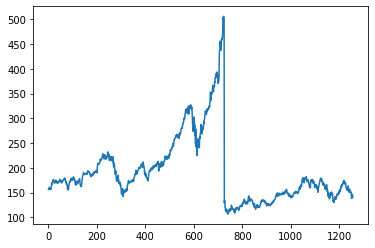

In [11]:
plt.plot(df1)

In [12]:
from sklearn.preprocessing import MinMaxScaler

In [60]:
from sklearn.metrics import mean_squared_error

In [13]:
scaler = MinMaxScaler()

In [23]:
df1 = np.asarray(df1).reshape(-1,1)
df1.shape

(1257, 1)

In [24]:
df1 = scaler.fit_transform(df1)  # scaling data between 0 and 1 for LSTM
df1

array([[0.12450845],
       [0.12313087],
       [0.12561052],
       ...,
       [0.09908579],
       [0.09665623],
       [0.08328115]])

In [30]:
# train test split
train_size = ceil(0.8*len(df1))
test_size = len(df1) - train_size

In [216]:
train_size, test_size

(1006, 251)

In [32]:
train_data, test_data = df1[ : train_size, 0], df1[train_size : , 0]
    #len(train_data) + len(test_data) = 1257

In [76]:
def create_dataset(dataset, time_step = 10) :      # creating matrix of features, target
    dataX, dataY =[], []                           # features -> stock price for first time_step days; target -> price on 
    N = len(dataset)                               # time_step+1 th day, etc
    for i in range(N - time_step) :
        dataX.append(dataset[i : i + time_step])
        dataY.append(dataset[i + time_step])
    return np.array(dataX), np.array(dataY)

In [77]:
time_step = 60
X_train, Y_train = create_dataset(train_data, time_step)
X_test, Y_test = create_dataset(test_data, time_step)

In [79]:
X_train.shape, Y_train.shape

((946, 60), (946,))

In [218]:
# reshape train and test input data in compliance with the LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
X_train.shape, X_test.shape

((946, 60, 1), (191, 60, 1))

In [81]:
## Create stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [82]:
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (time_step, 1)))
model.add(LSTM(50, return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [83]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 60, 50)            10400     
                                                                 
 lstm_4 (LSTM)               (None, 60, 50)            20200     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [84]:
model.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs = 100, batch_size = 64, verbose = 1)

Epoch 1/100
15/15 [==============================] - 6s 140ms/step - loss: 0.0232 - val_loss: 4.9371e-04
Epoch 2/100
15/15 [==============================] - 1s 73ms/step - loss: 0.0098 - val_loss: 4.7525e-04
Epoch 3/100
15/15 [==============================] - 1s 73ms/step - loss: 0.0075 - val_loss: 4.4287e-04
Epoch 4/100
15/15 [==============================] - 1s 74ms/step - loss: 0.0064 - val_loss: 3.8279e-04
Epoch 5/100
15/15 [==============================] - 1s 73ms/step - loss: 0.0053 - val_loss: 6.3361e-04
Epoch 6/100
15/15 [==============================] - 1s 78ms/step - loss: 0.0048 - val_loss: 3.9822e-04
Epoch 7/100
15/15 [==============================] - 1s 73ms/step - loss: 0.0044 - val_loss: 4.7191e-04
Epoch 8/100
15/15 [==============================] - 1s 73ms/step - loss: 0.0037 - val_loss: 4.0645e-04
Epoch 9/100
15/15 [==============================] - 1s 75ms/step - loss: 0.0040 - val_loss: 3.3287e-04
Epoch 10/100
15/15 [==============================] - 1s 73ms/s

15/15 [==============================] - 1s 89ms/step - loss: 0.0012 - val_loss: 2.3562e-04
Epoch 80/100
15/15 [==============================] - 1s 93ms/step - loss: 0.0011 - val_loss: 2.2282e-04
Epoch 81/100
15/15 [==============================] - 1s 100ms/step - loss: 0.0012 - val_loss: 3.3014e-04
Epoch 82/100
15/15 [==============================] - 2s 109ms/step - loss: 9.6958e-04 - val_loss: 5.0477e-04
Epoch 83/100
15/15 [==============================] - 1s 91ms/step - loss: 9.8809e-04 - val_loss: 2.6587e-04
Epoch 84/100
15/15 [==============================] - 2s 139ms/step - loss: 9.9903e-04 - val_loss: 2.2611e-04
Epoch 85/100
15/15 [==============================] - 2s 125ms/step - loss: 0.0013 - val_loss: 2.6638e-04
Epoch 86/100
15/15 [==============================] - 2s 128ms/step - loss: 0.0011 - val_loss: 4.8994e-04
Epoch 87/100
15/15 [==============================] - 2s 118ms/step - loss: 7.9160e-04 - val_loss: 2.0180e-04
Epoch 88/100
15/15 [==========================

In [110]:
train_predict = model.predict(X_train)  

30/30 [==============================] - 1s 17ms/step


In [111]:
test_predict = model.predict(X_test)

6/6 [==============================] - 0s 18ms/step


In [125]:
mean_squared_error(train_predict, Y_train)

0.0006692459642733735

In [126]:
mean_squared_error(test_predict, Y_test)

0.00019922627768760045

In [114]:
# creating proper arrays for plotting
train_predict_plot  = np.empty_like(df1)
train_predict_plot[:,:] = np.nan
train_predict_plot[time_step : train_size, : ] = train_predict

test_predict_plot  = np.empty_like(df1)
test_predict_plot[:,:] = np.nan
test_predict_plot[train_size + time_step : len(df1), : ] = test_predict

In [116]:
# inverse transform to get actual price values
train_predict_plot = scaler.inverse_transform(train_predict_plot)
test_predict_plot = scaler.inverse_transform(test_predict_plot)

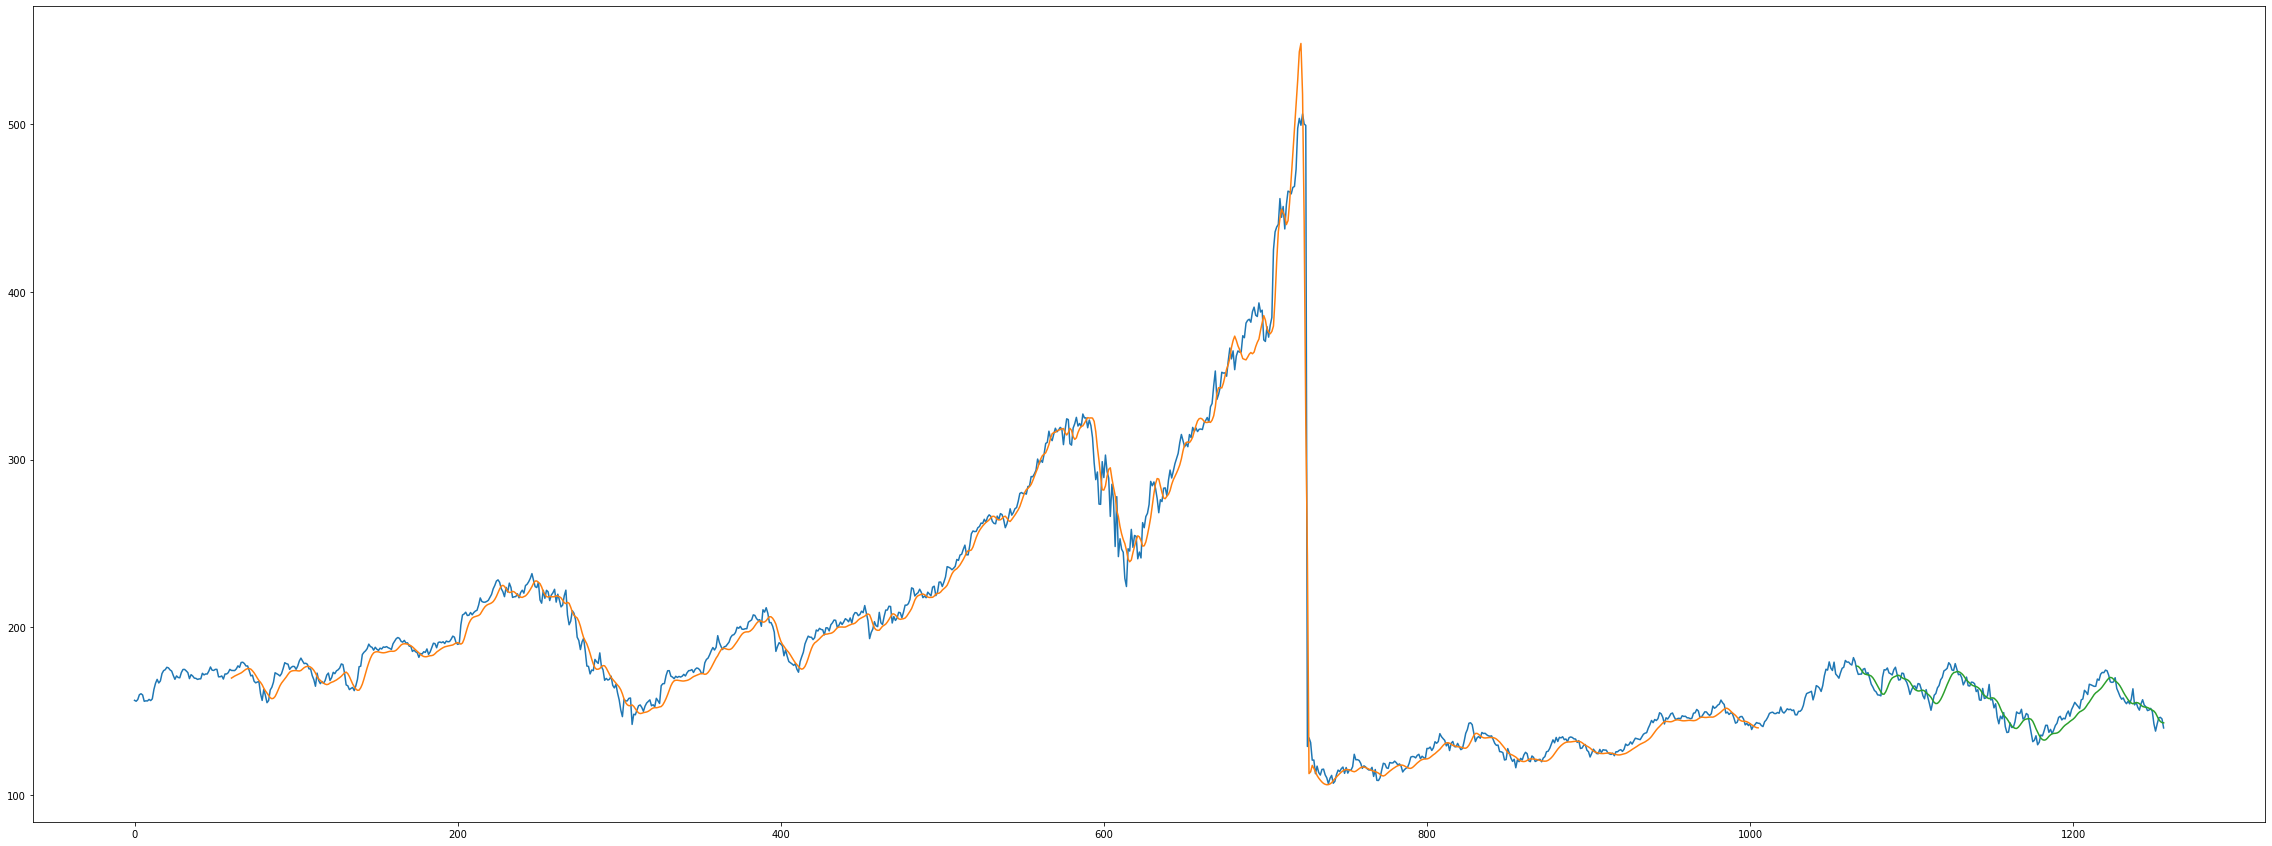

In [192]:
## Actual test data prediction with predicted values in input, i.e., without looking at actual prices in X_test, using predicted
## prices in X_test
input_data = df1[train_size : train_size + time_step, :]

In [194]:
input_data.shape  # shape = time_step

(1, 60, 1)

In [193]:
input_data = input_data.reshape(input_data.shape[1], input_data.shape[0], 1)

In [195]:
output_data = [] # store predicted price values here

In [196]:
for i in range(test_data.size - time_step) :
    output_data.append(model.predict(input_data)[0,0])    # predict 61st day price
    input_data = np.append(input_data, np.array([output_data[-1]]).reshape(1,-1,1) ,axis =1)  # add predicted price to input for next prediction
    input_data = input_data[:,1:,:]        # remove 1st day price value


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 23ms/step


In [200]:
output_data = np.array(output_data).reshape(-1,1)

In [211]:
# proper array for plotting
out_predict_plot  = np.empty_like(df1)
out_predict_plot[:,:] = np.nan
out_predict_plot[train_size + time_step : len(df1), : ] = output_data

out_predict_plot = scaler.inverse_transform(out_predict_plot)

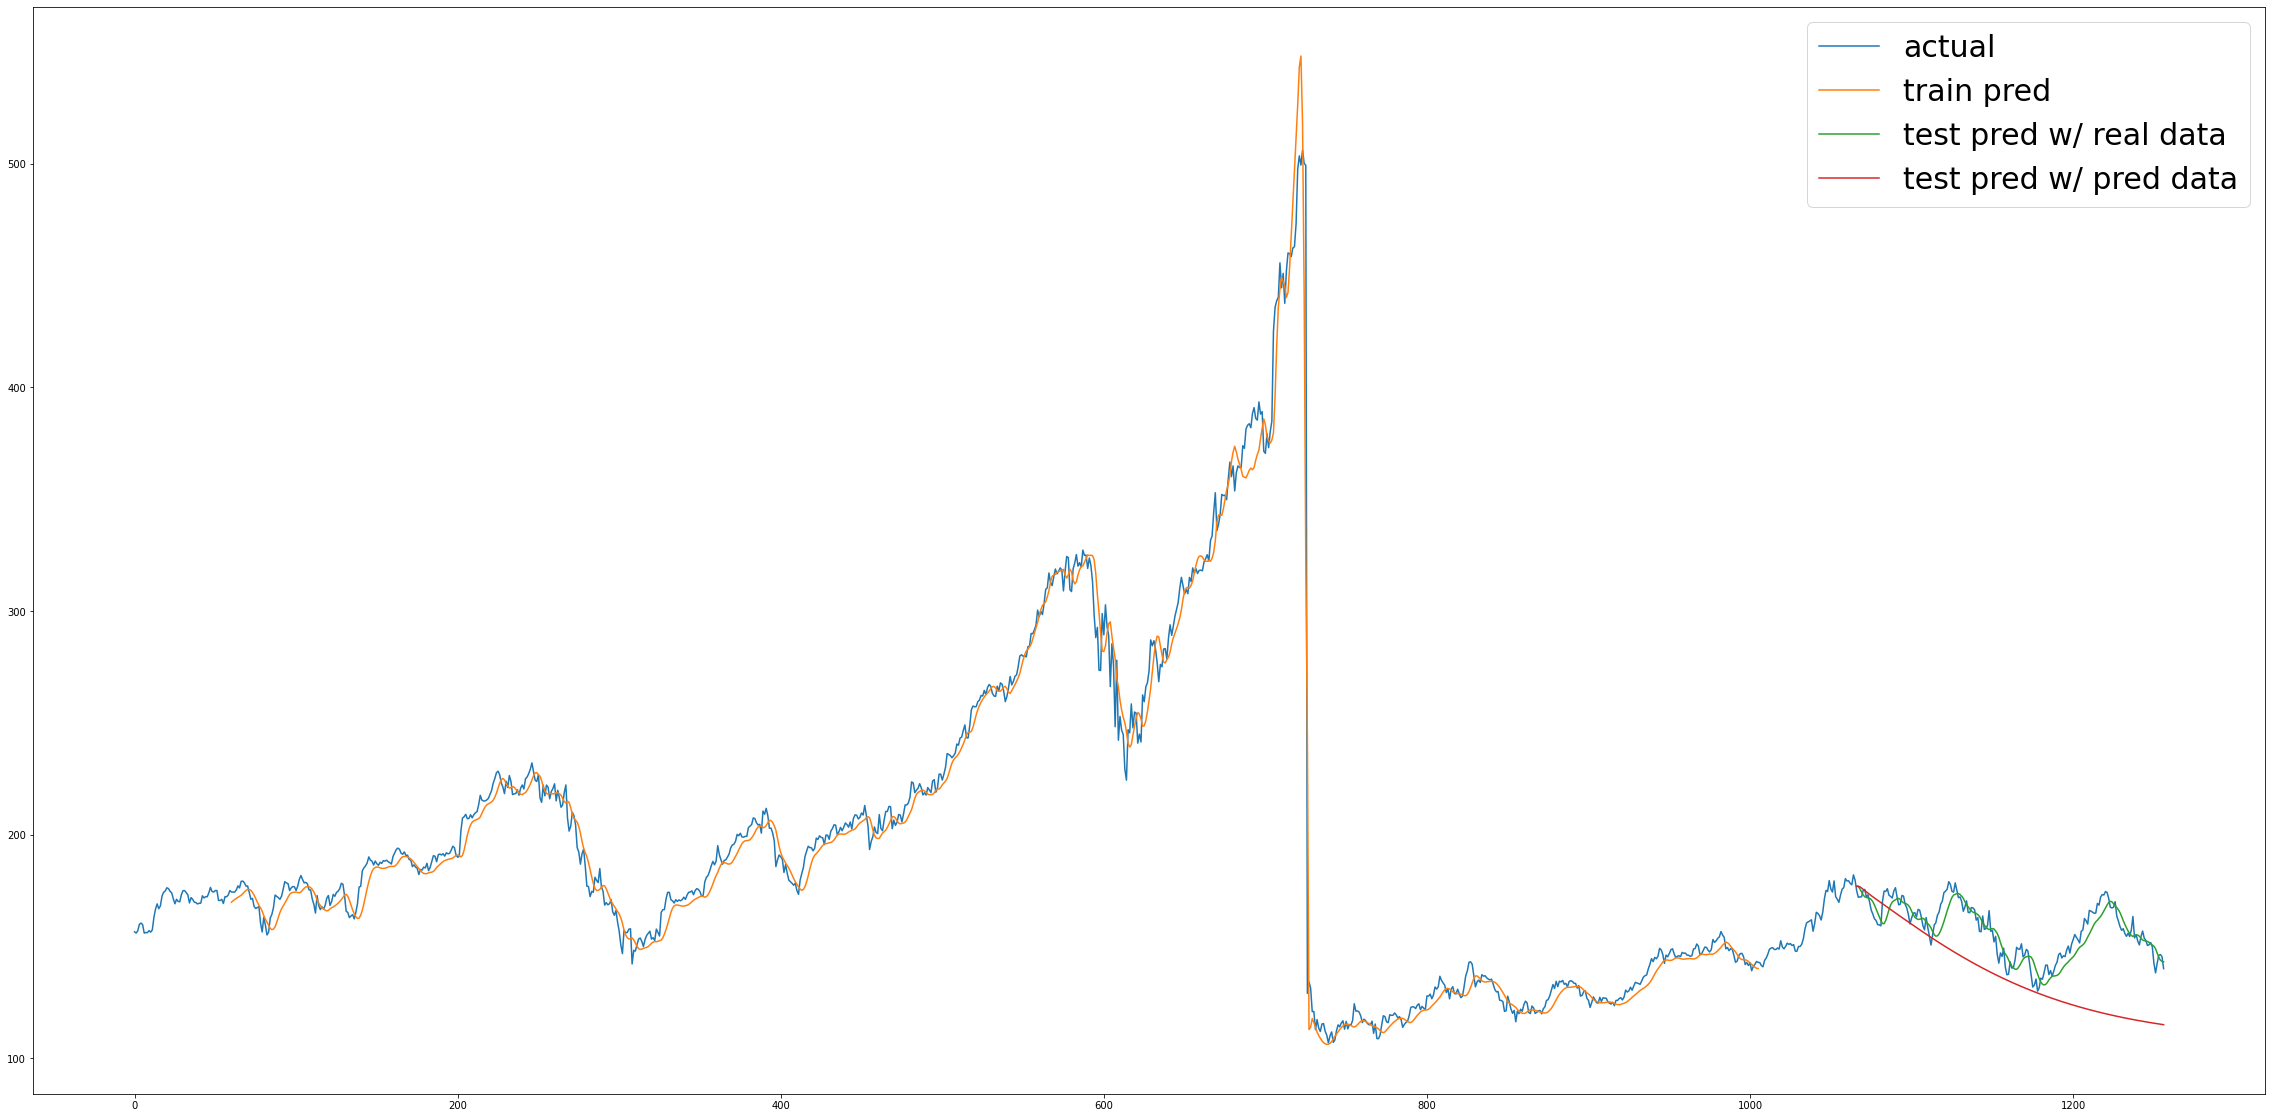

In [224]:
fig = plt.figure(figsize = (40,20))
plt.plot(scaler.inverse_transform(df1), label = 'actual')    #plots actual data
plt.plot(train_predict_plot, label = 'train pred')  # plots predicted data from training set
plt.plot(test_predict_plot, label = 'test pred w/ real data')   # plots predicted data with input being actual prices

plt.plot(out_predict_plot, label = 'test pred w/ pred data')   # plots predicted data with input being predicted prices
plt.legend(prop={'size': 30})
plt.show()